<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-3/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 3, Problem 5: DCGAN, WGAN, WGAN-GP

## Download Data

In [13]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -O /content/train-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -O /content/train-labels-idx1-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -O /content/test-images-idx3-ubyte.gz
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -O /content/test-labels-idx1-ubyte.gz
!pip install wandb
!wandb login

--2024-10-18 02:50:31--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.140.152, 52.219.171.196, 3.5.137.203, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.140.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘/content/train-images-idx3-ubyte.gz’

/content/train-imag 100%[===================>]  25.20M  19.2MB/s    in 1.3s    

2024-10-18 02:50:33 (19.2 MB/s) - ‘/content/train-images-idx3-ubyte.gz’ saved [26421880/26421880]

--2024-10-18 02:50:33--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.140.152, 

## Library Imports

In [14]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
import gzip
import typing as T
import wandb

torch.manual_seed(123)
np.random.seed(123)

# wandb.login()

## Check for GPU Access

In [15]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: True
MPS GPU Available: False
GPU Name: NVIDIA A100-SXM4-40GB
GPU Count: 1
GPU Memory Allocated: 7589888
GPU Memory Cached: 23068672


## Load Data

### Define FashionMNIST

In [16]:
class FasionMNISTDataset(Dataset):
    def __init__(self, path: str, kind: str, device=torch.device('cpu')) -> None:
        super().__init__()
        self.device = device
        self.labels, self.images = self._load_data(path, kind)

    def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
        with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
            lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
            lbls = np.copy(lbls)
        with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
            imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
            imgs = ((np.copy(imgs) / 255) * 2 - 1).astype(np.float32)
        return lbls, imgs

    def __len__(self) -> int:
        return self.labels.size

    def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
        img = torch.tensor(self.images[index])
        img = img.to(self.device)
        if self.labels is not None:
            label = torch.tensor(self.labels[index], dtype=torch.long)
            label = F.one_hot(label, num_classes=10).float().to(self.device)
            return img, label
        else:
            return img

def show_img(dataset: Dataset, index: int) -> None:
    img, label = dataset[index]
    labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
    label = torch.argmax(label)
    plt.imshow(img.cpu().reshape(28,28), cmap='gray')
    plt.title(labels_map[label.cpu().item()])
    plt.show()

gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset('/content', 'train', device=device)
test = FasionMNISTDataset('/content', 'test', device=device)

traindataloader = DataLoader(torch.utils.data.ConcatDataset([train,test]), batch_size=64, shuffle=True, generator=gen)
# testdataloader = DataLoader(test, batch_size=64, shuffle=True, generator=gen)

In [17]:
len(test)

10000

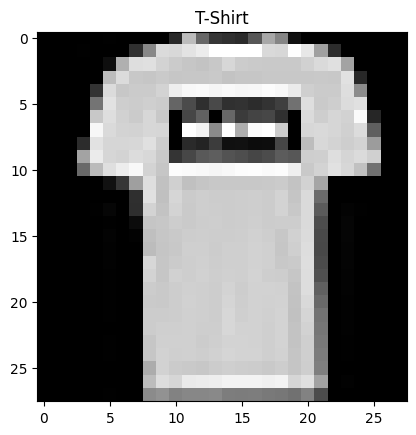

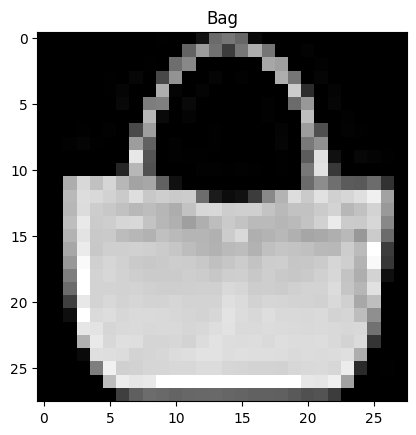

In [18]:
show_img(train, 1)
show_img(train, 100)

## Model Building

### GAN Modules

In [19]:
class SoftplusAdjusted(nn.Module):
    def __init__(self, beta=1.0, threshold=20.0):
        super().__init__()
        self.beta = beta
        self.threshold = threshold
        self.softplus = nn.Softplus(beta=self.beta, threshold=self.threshold)

    def forward(self, x):
        return self.softplus(2 * x + 2) / 2

class Norm(nn.Module):
    def __init__(self, model_type, arch_type, features, dims):
        super(Norm, self).__init__()
        if arch_type == 'a':
            if model_type != 'gp':
                if dims == 2:
                    self.norm = nn.BatchNorm2d(features)
                else:
                    self.norm = nn.BatchNorm1d(features)
            else:
                # For WGAN-GP, use LayerNorm over the channel dimension
                self.norm = nn.LayerNorm(features)
        else:
            self.norm = nn.Identity()

    def forward(self, x):
        if isinstance(self.norm, nn.LayerNorm):
            if x.dim() == 4:
                # x is [N, C, H, W]; bring channels to last dimension
                x = x.permute(0, 2, 3, 1)  # [N, H, W, C]
                x = self.norm(x)
                x = x.permute(0, 3, 1, 2)  # Back to [N, C, H, W]
            elif x.dim() == 3:
                # x is [N, C, L]; bring channels to last dimension
                x = x.permute(0, 2, 1)  # [N, L, C]
                x = self.norm(x)
                x = x.permute(0, 2, 1)  # Back to [N, C, L]
            else:
                x = self.norm(x)
            return x
        else:
            return self.norm(x)

class Discriminator(nn.Module):
    def __init__(self, model_type, arch_type, channels, num_classes, features):
        super().__init__()
        self.num_classes = num_classes
        self.seq = nn.Sequential(
            # Input: N x (channels + num_classes) x 28 x 28
            nn.Conv2d(channels + num_classes, features, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Conv2d(features, features * 2, kernel_size=4, stride=2, padding=1, bias=False),
            Norm(model_type, arch_type, features * 2, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Conv2d(features * 2, features * 4, kernel_size=4, stride=2, padding=1, bias=False),
            Norm(model_type, arch_type, features * 4, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Conv2d(features * 4, features * 8, kernel_size=3, stride=2, padding=0, bias=False),
            Norm(model_type, arch_type, features * 8, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            nn.Flatten(),
            nn.Linear(features * 8, 1),
            nn.Sigmoid() if model_type == 'dc' else nn.Identity()
        )
        self.apply(self.weights_init)

    def forward(self, x, labels):
        batch_size, _, height, width = x.shape
        labels = labels.view(batch_size, self.num_classes, 1, 1)
        labels = labels.repeat(1, 1, height, width)
        x = torch.cat((x, labels), dim=1)
        return self.seq(x).view(-1)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

class Generator(nn.Module):
    def __init__(self, model_type, arch_type, z_dim, num_classes, channels, features):
        super().__init__()
        self.num_classes = num_classes
        self.z_dim = z_dim
        self.seq = nn.Sequential(
            # Project and reshape
            nn.Linear(z_dim + num_classes, features * 8),
            Norm(model_type, arch_type, features * 8, 1),
            nn.Unflatten(1, (features * 8, 1, 1)),

            # First upsampling block
            nn.ConvTranspose2d(features * 8, features * 4, kernel_size=3, stride=2, padding=0, bias=False),
            Norm(model_type, arch_type, features * 4, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            # Second upsampling block
            nn.ConvTranspose2d(features * 4, features * 2, kernel_size=4, stride=2, padding=1, output_padding=1, bias=False),
            Norm(model_type, arch_type, features * 2, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            # Third upsampling block
            nn.ConvTranspose2d(features * 2, features, kernel_size=4, stride=2, padding=1, bias=False),
            Norm(model_type, arch_type, features, 2),
            nn.LeakyReLU(0.2, inplace=True) if arch_type == 'a' else SoftplusAdjusted(),

            # Output layer
            nn.ConvTranspose2d(features, channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()
        )
        self.apply(self.weights_init)

    def forward(self, noise, labels):
        batch_size = noise.size(0)
        # labels = labels.view(batch_size, self.num_classes, 1, 1)
        x = torch.cat((noise.squeeze(), labels), dim=1)
        return self.seq(x)

    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)

### DCGAN

In [20]:
class DCGAN:
    def __init__(self, arch_type, z_dim, num_classes, channels, features, device):
        self.z_dim = z_dim
        self.channels = channels
        self.features = features
        self.model_type = 'dc'
        self.arch_type = arch_type
        self.discriminator = Discriminator(self.model_type, arch_type, channels, num_classes, features).to(device)
        self.optim_discrim = optim.Adam(self.discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999)) #, betas=(0.5, 0.999)
        self.generator = Generator(self.model_type, arch_type, z_dim, num_classes, channels, features).to(device)
        self.optim_gen = optim.Adam(self.generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
        self.loss = nn.BCELoss()
        self.device = device

    def train_discriminator(self, real_imgs, real_labels, fake_labels, batch_size):
        self.optim_discrim.zero_grad()

        real_imgs = real_imgs.to(self.device)
        real_labels = real_labels.to(self.device)

        # Train on real images
        output_real = self.discriminator(real_imgs, real_labels).view(-1)
        real_targets = torch.ones_like(output_real)
        real_loss = self.loss(output_real, real_targets)
        real_loss.backward()
        avg_real = output_real.mean().item()

        # Generate fake images
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise, fake_labels)
        output_fake = self.discriminator(fake_imgs.detach(), fake_labels).view(-1)
        fake_targets = torch.zeros_like(output_fake)
        fake_loss = self.loss(output_fake, fake_targets)
        fake_loss.backward()
        avg_fake = output_fake.mean().item()

        discrim_loss = real_loss + fake_loss
        self.optim_discrim.step()

        return fake_imgs, discrim_loss.item(), avg_real, avg_fake


    def train_generator(self, fake_imgs, fake_labels):
        self.optim_gen.zero_grad()
        output = self.discriminator(fake_imgs, fake_labels).view(-1)
        real_targets = torch.ones_like(output)
        gen_loss = self.loss(output, real_targets)
        gen_loss.backward()
        self.optim_gen.step()
        return gen_loss.item(), output.mean().item()

    def train_one_epoch(self, train_loader, batch_size):
        for i, (real_imgs, real_labels) in enumerate(train_loader):
            current_batch_size = real_imgs.size(0)

            fake_labels = F.one_hot(torch.randint(0, 10, (current_batch_size,), device=self.device), num_classes=10).float()

            fake_imgs, discrim_loss, avg_real, avg_fake1 = self.train_discriminator(real_imgs, real_labels, fake_labels, current_batch_size)
            gen_loss, avg_fake2 = self.train_generator(fake_imgs, fake_labels)

            if i % 100 == 0 and i != 0:
                print(f'[{i}/{len(train_loader)}] DLoss: {discrim_loss:.4f} GLoss: {gen_loss: .4f}, D(x): {avg_real:.4f} D(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}')

            wandb.log({
                "Discriminator Loss": discrim_loss,
                "Generator Loss": gen_loss
            })


    def train(self, traindataloader, epochs, batch_size, noise):
        wandb.init(project='dcgan', config ={
            'epochs': epochs,
            'batch_size': batch_size,
            'noise': noise
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(traindataloader, batch_size)

        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')


In [21]:
wandb.finish()

In [22]:
dc = DCGAN('a', 100, 10, 1, 64, device)
dc.train(traindataloader, 10, 64, 100)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


----------- DCGAN Train Start! ------------
----------- Epoch #1 ------------
[100/1094] DLoss: 1.0285 GLoss:  0.9926, D(x): 0.6131 D(G(z)): 0.4066/0.3808
[200/1094] DLoss: 1.2110 GLoss:  0.8429, D(x): 0.5274 D(G(z)): 0.4272/0.4341
[300/1094] DLoss: 1.1776 GLoss:  0.9929, D(x): 0.6064 D(G(z)): 0.4811/0.3758
[400/1094] DLoss: 1.3124 GLoss:  1.0661, D(x): 0.4362 D(G(z)): 0.3475/0.3654
[500/1094] DLoss: 1.2072 GLoss:  1.0035, D(x): 0.5972 D(G(z)): 0.4794/0.3779
[600/1094] DLoss: 1.0509 GLoss:  1.0906, D(x): 0.5946 D(G(z)): 0.3999/0.3415
[700/1094] DLoss: 1.2072 GLoss:  1.0648, D(x): 0.5457 D(G(z)): 0.4336/0.3617
[800/1094] DLoss: 1.1740 GLoss:  0.9465, D(x): 0.5806 D(G(z)): 0.4355/0.4033
[900/1094] DLoss: 1.1768 GLoss:  1.0849, D(x): 0.5344 D(G(z)): 0.3982/0.3489
[1000/1094] DLoss: 1.3636 GLoss:  0.9728, D(x): 0.5049 D(G(z)): 0.4622/0.3950
----------- Epoch #2 ------------
[100/1094] DLoss: 1.1523 GLoss:  1.0805, D(x): 0.5706 D(G(z)): 0.4038/0.3573
[200/1094] DLoss: 1.0260 GLoss:  1.0035,

Discriminator Loss,▆██▆█▆▇█▅▆▅▇▇▅▄▆▅▃▅▅▄▇▆▄▃▃▅▄▃▅▂▂▄▅▆▄▂▃▁▅
Generator Loss,▁▁▁▂▁▃▃▂▁▃▄▃▃▄▃▁▂▄▅▄▅▅▄▃▄▆▄▆█▆▅▇▃▆▄▅▄▆▆▆
Discriminator Loss,0.48598
Generator Loss,3.04344


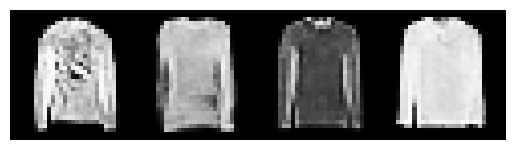

In [31]:
dc.generate_images(4, F.one_hot(torch.tensor([2]*4, device=dc.device), num_classes=10).float())

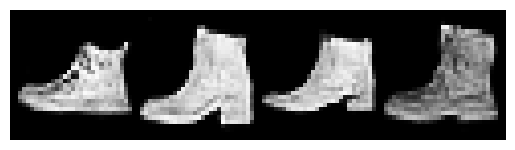

In [32]:
dc.generate_images(4, F.one_hot(torch.tensor([9]*4, device=dc.device), num_classes=10).float())

#### Save and Load Example

In [36]:
torch.save(dc.generator.state_dict(), '/content/drive/MyDrive/DL3/dc_generator_arch_a.pth')
torch.save(dc.discriminator.state_dict(), '/content/drive/MyDrive/DL3/dc_discriminator_arch_a.pth')

<ipython-input-26-8032c5cba0db>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tmp.load_state_dict(torch.load('/content/drive/MyDrive/DL3/dc_generator_arch_a.pth'))


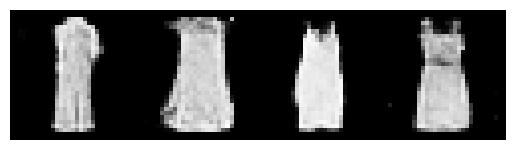

In [26]:
tmp = Generator('dc', 'a', 100, 10, 1, 64)
tmp.load_state_dict(torch.load('/content/drive/MyDrive/DL3/dc_generator_arch_a.pth'))

def generate_images(model, num_images, labels):
    model.generator.eval()
    with torch.no_grad():  # Disable gradient calculation
        noise = torch.randn(num_images, model.z_dim, 1, 1, device=model.device)
        generated_images = model.generator(noise, labels)
        # generated_images = (generated_images + 1) / 2
        grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
        np_grid = grid.permute(1, 2, 0).numpy()
        plt.imshow(np_grid)
        plt.axis('off')

generate_images(dc, 4, F.one_hot(torch.tensor([3]*4, device=device), num_classes=10).float())


In [27]:
dc2 = DCGAN('b', 100, 10, 1, 64, device)
dc2.train(traindataloader, 10, 64, 100)

----------- DCGAN Train Start! ------------
----------- Epoch #1 ------------
[100/1094] DLoss: 1.3662 GLoss:  0.6852, D(x): 0.4995 D(G(z)): 0.4893/0.5040
[200/1094] DLoss: 1.5971 GLoss:  0.2306, D(x): 0.3183 D(G(z)): 0.3620/0.7941
[300/1094] DLoss: 1.2428 GLoss:  0.7420, D(x): 0.5637 D(G(z)): 0.4874/0.4764
[400/1094] DLoss: 0.2894 GLoss:  2.3582, D(x): 0.8399 D(G(z)): 0.0439/0.0996
[500/1094] DLoss: 0.8363 GLoss:  1.7014, D(x): 0.8454 D(G(z)): 0.4544/0.2002
[600/1094] DLoss: 0.5509 GLoss:  1.3970, D(x): 0.7514 D(G(z)): 0.1638/0.2538
[700/1094] DLoss: 0.6966 GLoss:  1.4910, D(x): 0.6963 D(G(z)): 0.2254/0.2496
[800/1094] DLoss: 0.6218 GLoss:  2.1285, D(x): 0.7979 D(G(z)): 0.2553/0.1430
[900/1094] DLoss: 0.6706 GLoss:  2.2714, D(x): 0.7550 D(G(z)): 0.2325/0.2167
[1000/1094] DLoss: 0.6220 GLoss:  2.8089, D(x): 0.8238 D(G(z)): 0.2448/0.1479
----------- Epoch #2 ------------
[100/1094] DLoss: 1.0965 GLoss:  1.3414, D(x): 0.5949 D(G(z)): 0.3196/0.3172
[200/1094] DLoss: 1.0107 GLoss:  1.2630,

Discriminator Loss,█▂▂▂▂▁▅▂▅▆▆▅▅▆▅▆▅▅▅▆▆▆▅▆▅▆▅▆▅▇▅▆▆▆▆▅▅▅▅▆
Generator Loss,▁▁▁▁▁█▇▄▄▃▅▂▂▃▂▃▃▃▂▂▃▂▂▃▂▂▂▂▂▃▂▂▂▂▃▃▂▂▂▂
Discriminator Loss,1.18476
Generator Loss,1.14127


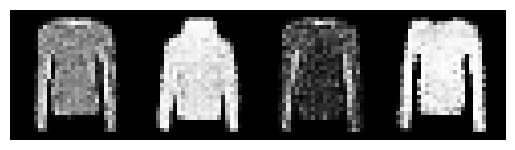

In [30]:
dc2.generate_images(4, F.one_hot(torch.tensor([2]*4, device=device), num_classes=10).float())

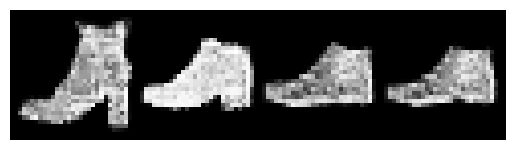

In [33]:
dc2.generate_images(4, F.one_hot(torch.tensor([9]*4, device=device), num_classes=10).float())

In [35]:
torch.save(dc2.generator.state_dict(), '/content/drive/MyDrive/DL3/dc_generator_arch_b.pth')
torch.save(dc2.discriminator.state_dict(), '/content/drive/MyDrive/DL3/dc_discriminator_arch_b.pth')

### WGAN with Clipping


In [37]:
def wasserstein_loss(real_preds, fake_preds):
    return torch.mean(fake_preds) - torch.mean(real_preds)

class WGAN:
    def __init__(self, arch_type, z_dim, channels, num_classes, features, device, clip_value=0.01, lr=0.00005):
        self.z_dim = z_dim
        self.clip_value = clip_value
        self.lr = lr
        self.device = device
        self.arch_type = arch_type
        self.model_type = 'clip'

        self.generator = Generator(self.model_type, self.arch_type, z_dim, num_classes, channels, features).to(device)
        self.critic = Discriminator(self.model_type, self.arch_type, channels, num_classes, features).to(device)
        self.loss = wasserstein_loss

        self.optim_critic = optim.RMSprop(self.critic.parameters(), lr=lr)
        self.optim_gen = optim.RMSprop(self.generator.parameters(), lr=lr)

    def train_critic(self, real_images, real_labels, fake_labels, batch_size):
        self.optim_critic.zero_grad()

        real_preds = self.critic(real_images, real_labels)

        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_images.detach(), fake_labels.detach())

        loss = self.loss(real_preds, fake_preds)
        loss.backward()
        self.optim_critic.step()

        for p in self.critic.parameters():
            p.data.clamp_(-self.clip_value, self.clip_value)

        return loss.item(), real_preds.mean().item(), fake_preds.mean().item()

    def train_generator(self, fake_labels, batch_size):
        self.optim_gen.zero_grad()

        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)
        fake_images = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_images, fake_labels)

        loss = -torch.mean(fake_preds)
        loss.backward()
        self.optim_gen.step()

        return loss.item(), fake_images.mean().item()

    def train_one_epoch(self, dataloader, n_critic=5):
        for i, (real_images, real_labels) in enumerate(dataloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(self.device)

            fake_labels = F.one_hot(torch.randint(0, 10, (batch_size,), device=self.device), num_classes=10).float()

            d_loss, avg_real, avg_fake1 = self.train_critic(real_images, real_labels, fake_labels, batch_size)

            if i % n_critic == 0:
                g_loss, avg_fake2 = self.train_generator(fake_labels, batch_size)
            else:
                g_loss, avg_fake2 = float('nan'), float('nan')

            if i % 100 == 0 and i != 0:
                print(f"Batch {i}/{len(dataloader)} "
                      f"Closs: {d_loss:.4f}, Gloss: {g_loss:.4f}, C(x): {avg_real:.4f} C(G(z)): {avg_fake1:.4f}/{avg_fake2:.4f}")

            wandb.log({
                "Discriminator Loss": d_loss,
                "Generator Loss": g_loss
            })

    def train(self, dataloader, num_epochs, n_critic=5):
        wandb.init(project='wgan', config ={
            'epochs': num_epochs,
            'lr':self.lr,
            'n_critic': n_critic,
            'clip_value': self.clip_value
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(num_epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(dataloader, n_critic)
            print(f'--------------------------------------')
        print(f'----------- {self.__class__.__name__} Train End! ------------')
        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')

In [38]:
wgan = WGAN('a', 100, 1, 10, 64, device, lr=0.0001)
wgan.train(traindataloader, 10, 5)

----------- WGAN Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -0.0048, Gloss: 0.0116, C(x): -0.0055 C(G(z)): -0.0103/-0.2126
Batch 200/1094 Closs: -0.0052, Gloss: 0.0113, C(x): -0.0071 C(G(z)): -0.0123/-0.3613
Batch 300/1094 Closs: -0.0059, Gloss: 0.0117, C(x): -0.0068 C(G(z)): -0.0127/-0.3919
Batch 400/1094 Closs: -0.0048, Gloss: 0.0120, C(x): -0.0055 C(G(z)): -0.0103/-0.3854
Batch 500/1094 Closs: -0.0063, Gloss: 0.0142, C(x): -0.0041 C(G(z)): -0.0104/-0.3965
Batch 600/1094 Closs: -0.0074, Gloss: 0.0124, C(x): -0.0053 C(G(z)): -0.0127/-0.4055
Batch 700/1094 Closs: -0.0080, Gloss: 0.0141, C(x): -0.0039 C(G(z)): -0.0119/-0.4123
Batch 800/1094 Closs: -0.0096, Gloss: 0.0150, C(x): -0.0037 C(G(z)): -0.0133/-0.4123
Batch 900/1094 Closs: -0.0088, Gloss: 0.0155, C(x): -0.0042 C(G(z)): -0.0130/-0.3989
Batch 1000/1094 Closs: -0.0100, Gloss: 0.0136, C(x): -0.0051 C(G(z)): -0.0151/-0.4029
--------------------------------------
----------- Epoch #2 ------------

Discriminator Loss,█▇▇▆▅▄▂▃▂▂▁▂▃▁▁▂▂▂▄▃▃▃▂▂▅▃▃▄▄▄▄▃▄▄▄▄▃▃▅▅
Generator Loss,▁ █ ▆ ▆▂ ▃ ▄
Discriminator Loss,-0.01014
Generator Loss,nan


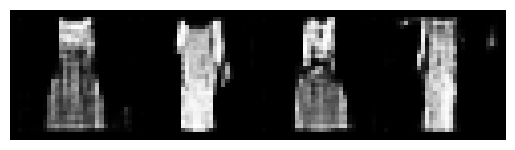

In [39]:
wgan.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgan.device), num_classes=10).float())

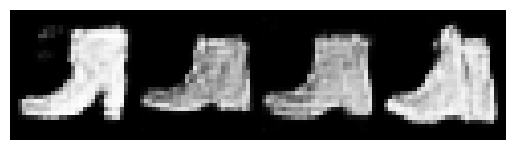

In [43]:
wgan.generate_images(4, F.one_hot(torch.tensor([9]*4, device=wgan.device), num_classes=10).float())

In [40]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_generator_arch_a.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_discriminator_arch_a.pth')

In [44]:
wgan2 = WGAN('b', 100, 1, 10, 64, device, lr=0.0001)
wgan2.train(traindataloader, 10, 5)

----------- WGAN Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -4.7983, Gloss: 64.8431, C(x): -53.8202 C(G(z)): -58.6185/-0.3791
Batch 200/1094 Closs: -49.3184, Gloss: 81.0215, C(x): -26.4000 C(G(z)): -75.7184/-0.3088
Batch 300/1094 Closs: -53.5961, Gloss: 136.9292, C(x): -94.7947 C(G(z)): -148.3908/-0.4444
Batch 400/1094 Closs: -82.8454, Gloss: 163.6208, C(x): -80.3765 C(G(z)): -163.2219/-0.3627
Batch 500/1094 Closs: -70.4396, Gloss: 200.6652, C(x): -118.1775 C(G(z)): -188.6171/-0.2685
Batch 600/1094 Closs: -65.3400, Gloss: 173.9105, C(x): -110.0514 C(G(z)): -175.3914/-0.3694
Batch 700/1094 Closs: -38.5934, Gloss: 110.7974, C(x): -81.9180 C(G(z)): -120.5114/-0.3284
Batch 800/1094 Closs: -86.6619, Gloss: 198.5407, C(x): -129.1476 C(G(z)): -215.8095/-0.2785
Batch 900/1094 Closs: -36.8272, Gloss: 186.7685, C(x): -106.3171 C(G(z)): -143.1443/-0.2193
Batch 1000/1094 Closs: -10.6993, Gloss: 118.2885, C(x): -102.2939 C(G(z)): -112.9932/-0.3260
------------

Discriminator Loss,▃▃▃▁▃▇▅██▄▅▇▆▇▆▅▆▅▅▆▇▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Generator Loss,▁ ▁ ▃ ▇ █
Discriminator Loss,-0.73716
Generator Loss,nan


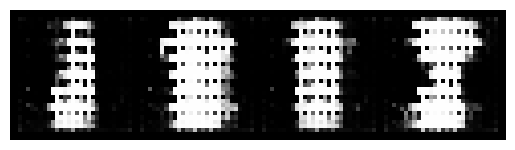

In [45]:
wgan2.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgan.device), num_classes=10).float())

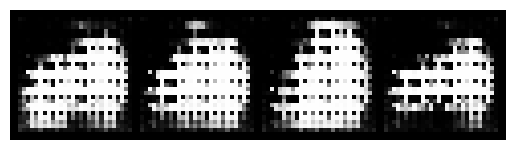

In [46]:
wgan2.generate_images(4, F.one_hot(torch.tensor([9]*4, device=wgan.device), num_classes=10).float())

In [47]:
torch.save(wgan2.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_generator_arch_b.pth')
torch.save(wgan2.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/wgan_discriminator_arch_b.pth')

### WGAN-GP

In [48]:
class WGAN_GP:
    def __init__(self, arch_type, z_dim, num_classes, channels, features, device, lr=0.0001, lambda_gp=10):
        self.z_dim = z_dim
        self.device = device
        self.lambda_gp = lambda_gp
        self.num_classes = num_classes
        self.lr = lr
        self.arch_type = arch_type
        self.model_type = 'gp'

        self.generator = Generator(self.model_type, arch_type, z_dim, num_classes, channels, features).to(device)
        self.critic = Discriminator(self.model_type, arch_type, channels, num_classes, features).to(device)

        self.optim_critic = optim.Adam(self.critic.parameters(), lr=self.lr, betas=(0.0, 0.9))
        self.optim_gen = optim.Adam(self.generator.parameters(), lr=self.lr, betas=(0.0, 0.9))

    def compute_gradient_penalty(self, real_imgs, real_labels, fake_imgs):
        alpha = torch.rand((real_imgs.size(0), 1, 1, 1), device=self.device)
        interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)
        d_interpolates = self.critic(interpolates, real_labels)
        fake = torch.ones(d_interpolates.size(), device=self.device)
        gradients = torch.autograd.grad(
            outputs=d_interpolates,
            inputs=interpolates,
            grad_outputs=fake,
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        return gradient_penalty

    def train_critic(self, fake_labels, real_imgs, real_labels, batch_size):
        self.optim_critic.zero_grad()
        noise = torch.randn(batch_size, self.z_dim, 1, 1, device=self.device)

        fake_imgs = self.generator(noise, fake_labels)
        real_preds = self.critic(real_imgs, real_labels)
        fake_preds = self.critic(fake_imgs.detach(), fake_labels)
        gradient_penalty = self.compute_gradient_penalty(real_imgs, real_labels, fake_imgs.detach())
        critic_loss = -torch.mean(real_preds) + torch.mean(fake_preds) + self.lambda_gp * gradient_penalty
        critic_loss.backward()
        self.optim_critic.step()
        return critic_loss

    def train_generator(self, fake_labels):
        self.optim_gen.zero_grad()
        noise = torch.randn(fake_labels.size(0), self.z_dim, 1, 1, device=self.device)
        fake_imgs = self.generator(noise, fake_labels)
        fake_preds = self.critic(fake_imgs, fake_labels)
        gen_loss = -torch.mean(fake_preds)
        gen_loss.backward()
        self.optim_gen.step()
        return gen_loss

    def train_one_epoch(self, dataloader, n_critic):
        gen_loss = None  # Initialize gen_loss
        for i, (real_imgs, real_labels) in enumerate(dataloader):
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(self.device)

            fake_labels = F.one_hot(torch.randint(0, 10, (batch_size,), device=self.device), num_classes=10).float()

            # Train Critic n_critic times
            for _ in range(n_critic):
                critic_loss = self.train_critic(fake_labels, real_imgs, real_labels, batch_size)
            # Train Generator

            gen_loss = self.train_generator(fake_labels)
            if i % 100 == 0 and i != 0:
                print(f"Batch {i}/{len(dataloader)} "
                      f"Closs: {critic_loss:.4f}, Gloss: {gen_loss:.4f}")

            wandb.log({
                "Critic Loss": critic_loss,
                "Generator Loss": gen_loss
            })

    def train(self, dataloader, num_epochs, n_critic=5):
        wandb.init(project='wgan-GP', config ={
            'epochs': num_epochs,
            'lr':self.lr,
            'n_critic': n_critic,
            'lambda_gp': self.lambda_gp
        })
        print(f'----------- {self.__class__.__name__} Train Start! ------------')
        for epoch in range(num_epochs):
            print(f'----------- Epoch #{epoch + 1} ------------')
            self.train_one_epoch(dataloader, n_critic)
            print(f'--------------------------------------')
        print(f'----------- {self.__class__.__name__} Train End! ------------')
        wandb.finish()

    def generate_images(self, num_images, labels):
        self.generator.eval()
        with torch.no_grad():  # Disable gradient calculation
            noise = torch.randn(num_images, self.z_dim, 1, 1, device=self.device)
            generated_images = self.generator(noise, labels)
            # generated_images = (generated_images + 1) / 2
            grid = torchvision.utils.make_grid(generated_images.cpu(), nrow=4, padding=2, normalize=True)
            np_grid = grid.permute(1, 2, 0).numpy()
            plt.imshow(np_grid)
            plt.axis('off')

In [49]:
wgangp = WGAN_GP('a', 100, 10, 1, 64, device)
wgangp.train(traindataloader, 10, 5)

----------- WGAN_GP Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -11.1796, Gloss: 7.1779
Batch 200/1094 Closs: -13.1055, Gloss: 3.8825
Batch 300/1094 Closs: -12.2636, Gloss: 9.5409
Batch 400/1094 Closs: -18.7572, Gloss: 26.4000
Batch 500/1094 Closs: -11.0109, Gloss: 6.9092
Batch 600/1094 Closs: -23.5072, Gloss: 27.0466
Batch 700/1094 Closs: -13.2446, Gloss: -10.4294
Batch 800/1094 Closs: -18.4976, Gloss: 49.0784
Batch 900/1094 Closs: -22.2406, Gloss: 39.1475
Batch 1000/1094 Closs: -31.2134, Gloss: 1.7787
--------------------------------------
----------- Epoch #2 ------------
Batch 100/1094 Closs: -34.1616, Gloss: 5.9968
Batch 200/1094 Closs: -46.4479, Gloss: 25.5716
Batch 300/1094 Closs: -23.2516, Gloss: 42.6684
Batch 400/1094 Closs: -8.5242, Gloss: -89.5452
Batch 500/1094 Closs: -24.2726, Gloss: 99.5639
Batch 600/1094 Closs: 5.0018, Gloss: 18.6400
Batch 700/1094 Closs: -17.4742, Gloss: -15.3491
Batch 800/1094 Closs: 2.2232, Gloss: 57.0430
Batch 90

Critic Loss,▅▅▅▅▅▅▅▅▆▅▅▅▅▅▅▅▅▆▆▄▅▅▅▆▄▅▅▆▆▄▄▄▃▃▄▆█▄▁▄
Generator Loss,▃▃▃▃▃▄▄▃▄▃▃▃▃▄▄▄▄▄▄▃▄▅▃▆▁▄▇▆▄▅▅▄█▄▁▃▅▄▇▂
Critic Loss,52.39618
Generator Loss,-106.81404


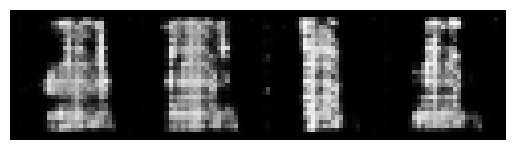

In [50]:
wgangp.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgangp.device), num_classes=10).float())

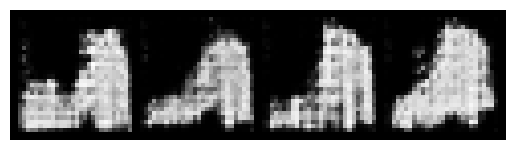

In [51]:
wgangp.generate_images(4, F.one_hot(torch.tensor([9]*4, device=wgangp.device), num_classes=10).float())

In [52]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_generator_arch_a.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_discriminator_arch_a.pth')

In [53]:
wgangp2 = WGAN_GP('b', 100, 10, 1, 64, device, lr=0.00001)
wgangp2.train(traindataloader, 10, 5)

----------- WGAN_GP Train Start! ------------
----------- Epoch #1 ------------
Batch 100/1094 Closs: -10.7606, Gloss: 16.2792
Batch 200/1094 Closs: -11.8205, Gloss: -7.8875
Batch 300/1094 Closs: -11.6845, Gloss: -35.4240
Batch 400/1094 Closs: -14.3845, Gloss: -44.7030
Batch 500/1094 Closs: -15.1853, Gloss: -52.1203
Batch 600/1094 Closs: -15.7603, Gloss: -65.7363
Batch 700/1094 Closs: -17.1394, Gloss: -71.3657
Batch 800/1094 Closs: -15.7753, Gloss: -73.6242
Batch 900/1094 Closs: -16.9964, Gloss: -78.1227
Batch 1000/1094 Closs: -16.0803, Gloss: -85.9299
--------------------------------------
----------- Epoch #2 ------------
Batch 100/1094 Closs: -14.2826, Gloss: -98.8089
Batch 200/1094 Closs: -12.9011, Gloss: -110.2277
Batch 300/1094 Closs: -14.3865, Gloss: -119.1242
Batch 400/1094 Closs: -13.1284, Gloss: -134.1105
Batch 500/1094 Closs: -13.5449, Gloss: -141.4346
Batch 600/1094 Closs: -12.8384, Gloss: -149.4075
Batch 700/1094 Closs: -14.9063, Gloss: -158.2396
Batch 800/1094 Closs: -13.

Critic Loss,▆▆▆▆▆▆▆▆▆▆▆▆▆▅▆▆▇▆▆▆▆▇▅▆▅▇▇▇▅▆▇█▆▅▇▅▆▁▄▆
Generator Loss,███████▇▇▇▇▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▂
Critic Loss,-10.36827
Generator Loss,-1119.3103


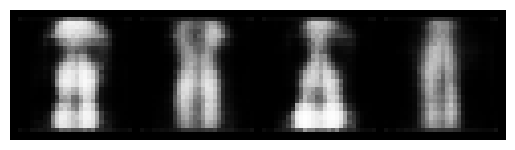

In [54]:
wgangp2.generate_images(4, F.one_hot(torch.tensor([3]*4, device=wgangp.device), num_classes=10).float())

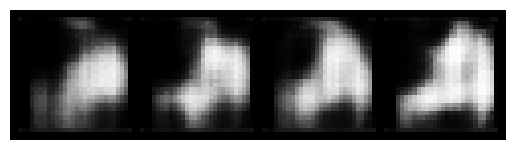

In [58]:
wgangp2.generate_images(4, F.one_hot(torch.tensor([9]*4, device=wgangp.device), num_classes=10).float())

In [59]:
torch.save(wgan.generator.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_generator_arch_b.pth')
torch.save(wgan.critic.cpu().state_dict(), '/content/drive/MyDrive/DL3/gp_discriminator_arch_b.pth')